In [1]:
# import modules
import uproot, sys, time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import awkward as ak
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FormatStrFormatter

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 14.0 # Use 14 point font
sns.set(style="whitegrid")

In [2]:
def getWeight(fb, sample):
    lumi = 25767.5
    weight = fb['mconly_weight']/fb['mc_weight_sum']*fb['xsec_ami']*fb['filter_eff_ami']*fb['kfactor_ami']*fb['pu_weight']*fb['jvt_weight']*1000*lumi
    if sample in ['ggHyyd','WH','VBF','ZH'] : 
        xsec_sig = 0.052 #if ( period == 'Run3' or 'mc23' in period ) else 0.048
        # if sample != 'ggHyyd' : xsec_sig = fb['xsec_ami']
        br = 0.01
        weight = fb['mconly_weight']/fb['mc_weight_sum']*xsec_sig*fb['pu_weight']*fb['jvt_weight']*fb['filter_eff_ami']*fb['kfactor_ami']*1000*lumi*br
    return weight

def getSampleDict():
    sample_dict = {}
    sample_dict['Zjets'] = {
        'color': 'darkgreen',   # approximates ROOT.kGreen-2
        'legend': r'Z($\nu\nu$, ll)+jets',
        'tree': 'nominal',
        'filenames': ['Zjets']
    }
    sample_dict['Zgamma'] = {
        'color': '#e6550d',      # approximates ROOT.kOrange+7
        'legend': r'Z($\nu\nu$)+$\gamma$',
        'tree': 'nominal',
        'filenames': ['Zgamma']
    }
    sample_dict['Wgamma'] = {
        'color': 'darkorange',  # approximates ROOT.kOrange+1
        'legend': r'W($l\nu$)+$\gamma$',
        'tree': 'nominal',
        'filenames': ['Wgamma']
    }
    sample_dict['Wjets'] = {
        'color': 'teal',        # approximates ROOT.kTeal+5
        'legend': r'W($l\nu$)+jets',
        'tree': 'nominal',
        'filenames': ['Wjets']
    }
    sample_dict['gammajet_direct'] = {
        'color': 'royalblue',   # approximates ROOT.kBlue+2
        'legend': r'$\gamma$+jets direct',
        'tree': 'gammajets',
        'filenames': ['gammajet_direct']
    }
    sample_dict['gammajet_frag'] = {
        'color': 'navy',        # approximates ROOT.kBlue-5
        'legend': r'$\gamma$+jets frag',
        'tree': 'gammajets',
        'filenames': ['gammajet_frag']
    }
    sample_dict['dijet'] = {
        'color': 'cyan',        # approximates ROOT.kCyan+1
        'legend': 'multijets',
        'tree': 'dijets',
        'filenames': ['dijet']
    }
    sample_dict['ggHyyd'] = {
        'color': 'red',         # approximates ROOT.kRed
        'legend': r'ggH, H$\rightarrow\gamma\gamma_{d}$',
        'tree': 'nominal',
        'filenames': ['ggHyyd']
    }
    return sample_dict
sample_dict = getSampleDict()

def getVarDict(fb, process, var_name=None):
    var_dict = {}

    # Define each variable's settings with an optional check to compute only when needed
    if var_name is None or var_name == 'vtx_sumPt':
        var_dict['vtx_sumPt'] = {
            'var': ak.flatten(fb['vtx_sumPt']),
            'bins': np.linspace(0, 100, 21),  # 21 edges for 20 bins
            'title': r'vtx\_sumPt'
        }

    if var_name is None or var_name == 'n_ph':
        var_dict['n_ph'] = {
            'var': fb['n_ph'],
            'bins': np.linspace(0, 7, 7+1),
            'title': r'$N_{ph}$'
        }

    if var_name is None or var_name == 'n_ph_baseline':
        var_dict['n_ph_baseline'] = {
            'var': fb['n_ph_baseline'],
            'bins': np.linspace(0, 7, 7+1),
            'title': r'$N_{ph\_baseline}$'
        }

    if var_name is None or var_name == 'n_el_baseline':
        var_dict['n_el_baseline'] = {
            'var': fb['n_el_baseline'],
            'bins': np.linspace(0, 7, 7+1),
            'title': r'$N_{el\_baseline}$'
        }

    if var_name is None or var_name == 'n_mu_baseline':
        var_dict['n_mu_baseline'] = {
            'var': fb['n_mu_baseline'],
            'bins': np.linspace(0, 7, 7+1),
            'title': r'$N_{mu\_baseline}$'
        }

    if var_name is None or var_name == 'n_tau_baseline':
        var_dict['n_tau_baseline'] = {
            'var': fb['n_tau_baseline'],
            'bins': np.linspace(0, 7, 7+1),
            'title': r'$N_{tau\_baseline}$'
        }

    if var_name is None or var_name == 'puWeight':
        var_dict['puWeight'] = {
            'var': fb['pu_weight'],
            'bins': np.linspace(0, 2, 50+1),
            'title': r'PU weight',
            'shift': '+0'
        }

    if var_name is None or var_name == 'actualIntPerXing':
        var_dict['actualIntPerXing'] = {
            'var': fb['actualIntPerXing'],
            'bins': np.linspace(0, 100, 50+1),
            'title': r'$\langle\mu\rangle$',
            'shift': '+0'
        }

    if var_name is None or var_name == 'mt':
        var_dict['mt'] = {
            'var': np.sqrt(2 * fb['met_tst_et'] * ak.firsts(fb['ph_pt']) * 
                           (1 - np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi'])))) / 1000,
            'bins': np.linspace(0, 300, 15+1),
            'title': r'$m_T\ [GeV]$',
            'shift': '+0'
        }

    if var_name is None or var_name == 'metsig':
        var_dict['metsig'] = {
            'var': fb['met_tst_sig'],
            'bins': np.linspace(0, 30, 15+1),
            'title': r'$E_T^{miss}\ significance$',
            'shift': '*1'
        }
    
    if var_name is None or var_name == 'metsigres':
        var_dict['metsigres'] = {
            'var': fb['met_tst_et'] / fb['met_tst_sig'],
            'bins': np.linspace(0, 100000, 50+1),
            'title': r'$E_T^{miss}\ significance$',
            'shift': '*1'
        }

    if var_name is None or var_name == 'met':
        var_dict['met'] = {
            'var': fb['met_tst_et'],
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{miss}\ [GeV]$',
            'shift': '+50000'
        }

    if var_name is None or var_name == 'met_noJVT':
        var_dict['met_noJVT'] = {
            'var': fb['met_tst_noJVT_et'],
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{miss}\ [GeV]$'
        }

    if var_name is None or var_name == 'met_cst':
        var_dict['met_cst'] = {
            'var': fb['met_cst_et'],
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{miss}\ CST\ [GeV]$'
        }

    if var_name is None or var_name == 'met_track':
        var_dict['met_track'] = {
            'var': fb['met_track_et'],
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{miss}\ Track\ [GeV]$'
        }

    if var_name is None or var_name == 'dmet':
        var_dict['dmet'] = {
            'var': fb['met_tst_noJVT_et'] - fb['met_tst_et'],
            'bins': np.linspace(-100000, 100000, 20+1),
            'title': r'$E_{T,\mathrm{noJVT}}^{miss}-E_T^{miss}\ [GeV]$',
            'shift': '*1'
        }

    if var_name is None or var_name == 'ph_pt':
        var_dict['ph_pt'] = {
            'var': ak.firsts(fb['ph_pt']),
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$p_T^{\gamma}\ [GeV]$',
            'shift': '-150000'
        }

    if var_name is None or var_name == 'ph_eta':
        var_dict['ph_eta'] = {
            'var': np.abs(ak.firsts(fb['ph_eta'])),
            'bins': np.linspace(0, 4, 16+1),
            'title': r'$\eta^{\gamma}$'
        }

    if var_name is None or var_name == 'ph_phi':
        var_dict['ph_phi'] = {
            'var': ak.firsts(fb['ph_phi']),
            'bins': np.linspace(-4, 4, 50+1),
            'title': r'$\phi^{\gamma}$'
        }


    #     # Jet central eta (first element)
    # var_dict['jet_central_eta'] = {
    #     'var': ak.firsts(fb['jet_central_eta']),
    
    #     'bins': np.linspace(-4, 4, 50+1), 
    #     'title': r'$\eta^{\mathrm{jets}}$'
    # }
    # # Jet central pt1 (first jet)
    # var_dict['jet_central_pt1'] = {
    #     'var': ak.firsts(fb['jet_central_pt']),
    
    #     'bins': np.linspace(0, 300000, 50+1),
    #     'title': r'$p_T^{j1}\ [GeV]$'
    # }
    # # Jet central pt2 (second jet, if available)
    # var_dict['jet_central_pt2'] = {
    #     'var': fb['jet_central_pt'][ak.num(fb['jet_central_pt']) >= 2][:, 1],
    
    #     'bins': np.linspace(0, 300000, 50+1),
    #     'title': r'$p_T^{j2}\ [GeV]$'
    # }
    # # Jet central pt (all jets)
    # var_dict['jet_central_pt'] = {
    #     'var': fb['jet_central_pt'],
    
    #     'bins': np.linspace(0, 300000, 50+1),
    #     'title': r'$p_T^{j}\ [GeV]$'
    # }

    # Delta phi (met vs. photon term)
    if var_name is None or var_name == 'dphi_met_phterm':
        var_dict['dphi_met_phterm'] = {
            'var': np.arccos(np.cos(fb['met_tst_phi'] - fb['met_phterm_phi'])),
            'bins': np.linspace(0, 4, 16+1),
            'title': r'$\Delta\phi(E_T^{miss},\, E_T^{\gamma})$',
            'shift': '+0'
        }

    if var_name is None or var_name == 'dphi_met_ph':
        var_dict['dphi_met_ph'] = {
            'var': np.arccos(np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi']))),
            'bins': np.linspace(0, 4, 50+1),
            'title': r'$\Delta\phi(E_T^{miss},\, E_T^{\gamma})$'
        }

    if var_name is None or var_name == 'dphi_met_jetterm':
        var_dict['dphi_met_jetterm'] = {
            'var': np.where(fb['met_jetterm_et'] != 0,
                            np.arccos(np.cos(fb['met_tst_phi'] - fb['met_jetterm_phi'])),
                            0),
            'bins': np.linspace(0, 4, 16+1),
            'title': r'$\Delta\phi(E_T^{miss},\, E_T^{jet})$'
        }

    if var_name is None or var_name == 'dphi_phterm_jetterm':
        var_dict['dphi_phterm_jetterm'] = {
            'var': np.where(fb['met_jetterm_et'] > 0,
                            np.arccos(np.cos(fb['met_phterm_phi'] - fb['met_jetterm_phi'])),
                            4),
            'bins': np.linspace(0, 4, 50+1),
            'title': r'$\Delta\phi(E_T^{\gamma},\, E_T^{jet})$'
        }
    # # Delta phi (photon vs. central jet1)
    # var_dict['dphi_ph_centraljet1'] = {
    #     'var': np.arccos(np.cos(ak.firsts(fb['ph_phi']) - ak.firsts(fb['jet_central_phi']))),
    
    #     'bins': np.linspace(0, 4, 50+1),
    #     'title': r'$\Delta\phi(\gamma,\, j1)$'
    # }
    # # Delta phi (photon vs. jet1) – duplicate of above; you can remove if redundant
    # var_dict['dphi_ph_jet1'] = {
    #     'var': np.arccos(np.cos(ak.firsts(fb['ph_phi']) - ak.firsts(fb['jet_central_phi']))),
    
    #     'bins': np.linspace(0, 4, 50+1),
    #     'title': r'$\Delta\phi(\gamma,\, j1)$'
    # }
    # # Delta phi (central jet1 vs. jet2)
    # var_dict['dphi_central_jet1_jet2'] = {
    #     'var': np.arccos(np.cos(fb['jet_central_phi'][0] - fb['jet_central_phi'][1])),
    
    #     'bins': np.linspace(0, 4, 50+1),
    #     'title': r'$\Delta\phi(j1,\, j2)$'
    # }
    # Met plus photon pt
    if var_name is None or var_name == 'metplusph':
        var_dict['metplusph'] = {
            'var': fb['met_tst_et'] + ak.firsts(fb['ph_pt']),
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{miss}+p_T^{\gamma}\ [GeV]$'
        }
    # # Fail JVT jet pt (all)
    # var_dict['failJVT_jet_pt'] = {
    #     'var': fb['failJVT_jet_pt'],
    
    #     'bins': np.linspace(0, 300000, 50+1),
    #     'title': r'$p_T^{\mathrm{noJVT\ jet}}\ [GeV]$'
    # }
    # # Fail JVT jet pt1 (first element)
    # var_dict['failJVT_jet_pt1'] = {
    #     'var': ak.firsts(fb['failJVT_jet_pt']),
    
    #     'bins': np.linspace(20000, 60000, 40+1),
    #     'title': r'$p_T^{\mathrm{noJVT\ jet1}}\ [GeV]$'
    # }
    if var_name is None or var_name == 'softerm':
        var_dict['softerm'] = {
            'var': fb['met_softerm_tst_et'],
            'bins': np.linspace(0, 100000, 50+1),
            'title': r'$E_T^{soft}\ [GeV]$'
        }

    if var_name is None or var_name == 'jetterm':
        var_dict['jetterm'] = {
            'var': fb['met_jetterm_et'],
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{jet}\ [GeV]$'
        }

    if var_name is None or var_name == 'jetterm_sumet':
        var_dict['jetterm_sumet'] = {
            'var': fb['met_jetterm_sumet'],
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{jet}\ [GeV]$'
        }

    if var_name is None or var_name == 'n_jet':
        var_dict['n_jet'] = {
            'var': fb['n_jet'],
            'bins': np.linspace(0, 10, 10+1),
            'title': r'$N_{jet}$'
        }

    if var_name is None or var_name == 'n_jet_central':
        var_dict['n_jet_central'] = {
            'var': fb['n_jet_central'],
            'bins': np.linspace(0, 10, 10+1),
            'title': r'$N_{jet}^{central}$'
        }

    if var_name is None or var_name == 'n_jet_fwd':
        var_dict['n_jet_fwd'] = {
            'var': fb['n_jet'] - fb['n_jet_central'],
            'bins': np.linspace(0, 10, 10+1),
            'title': r'$N_{jet}^{fwd}$'
        }

    if var_name is None or var_name == 'vertex':
        var_dict['vertex'] = {
            'var': (np.abs(ak.firsts(fb['pv_truth_z']) - ak.firsts(fb['pv_z'])) == 
                    np.min(np.abs(ak.firsts(fb['pv_truth_z']) - fb['pv_z']))),
            'bins': np.linspace(0, 2, 2+1),
            'title': r'good PV'
        }

    if var_name is None or var_name == 'goodPV':
        var_dict['goodPV'] = {
            'var': (np.abs(ak.firsts(fb['pv_truth_z']) - ak.firsts(fb['pv_z'])) <= 0.5),
            'bins': np.linspace(0, 2, 2+1),
            'title': r'good PV'
        }
    # # Delta phi (met vs. central jet)
    # var_dict['dphi_met_central_jet'] = {
    #     'var': np.arccos(np.cos(fb['met_tst_phi'] - ak.firsts(fb['jet_central_phi']))),
    
    #     'bins': np.linspace(0, 4, 50+1),
    #     'title': r'$\Delta\phi(E_T^{miss},\, jet)$'
    # }
    # # Counts: constant 0.5 (typically used for normalization)
    # var_dict['counts'] = {
    #     'var': 0.5,
    
    #     'bins': np.linspace(0, 1, 1+1),
    #     'title': ''
    # }
    # # Jet central timing1
    # var_dict['jet_central_timing1'] = {
    #     'var': ak.firsts(fb['jet_central_timing']),
    
    #     'bins': np.linspace(-40, 40, 50+1),
    #     'title': r'$Jet\ timing$'
    # }
    # # Jet central timing (all)
    # var_dict['jet_central_timing'] = {
    #     'var': fb['jet_central_timing'],
    
    #     'bins': np.linspace(-40, 40, 50+1),
    #     'title': r'$Jet\ timing$'
    # }
    # # Jet central EM fraction
    # var_dict['jet_central_emfrac'] = {
    #     'var': fb['jet_central_emfrac'],
    
    #     'bins': np.linspace(-1, 2, 50+1),
    #     'title': r'$Jet\ EM\ fraction$'
    # }
    # # Jet central EM fraction1
    # var_dict['jet_central_emfrac1'] = {
    #     'var': ak.firsts(fb['jet_central_emfrac']),
    
    #     'bins': np.linspace(-1, 2, 50+1),
    #     'title': r'$Jet\ EM\ fraction$'
    # }

    # Balance: (met_tst_et+ph_pt[0]) divided by the sum over jet_central_pt.

    if var_name is None or var_name == 'balance':
        jet_sum_tmp = ak.sum(fb['jet_central_pt'], axis=-1)
        mask = jet_sum_tmp != 0  # True for events where jet_sum is not 0.
        expr = (fb['met_tst_et'] + ak.firsts(fb['ph_pt'])) / jet_sum_tmp
        balance = expr[mask]

        var_dict['balance'] = {
            'var': balance,
            'weight': getWeight(fb, process)[mask],
            'bins': np.linspace(0, 20, 100+1),
            'title': r'balance'
        }

    if var_name is None or var_name == 'balance_sumet':
        var_dict['balance_sumet'] = {
            'var': (fb['met_tst_et'] + ak.firsts(fb['ph_pt'])) / fb['met_jetterm_sumet'],
            'bins': np.linspace(0, 80, 80+1),
            'title': r'balance'
        }

    if var_name is None or var_name == 'central_jets_fraction':
        var_dict['central_jets_fraction'] = {
            'var': np.where(fb['n_jet'] > 0, fb['n_jet_central']/fb['n_jet'], -1),
            'bins': np.linspace(-1, 2, 50+1),
            'title': r'Central jets fraction'
        }

    if var_name is None or var_name == 'trigger':
        var_dict['trigger'] = {
            'var': fb['trigger_HLT_g50_tight_xe40_cell_xe70_pfopufit_80mTAC_L1eEM26M'],
            'bins': np.linspace(0, 2, 2+1),
            'title': r'Pass Trigger'
        }

    # dphi_jj: Use Alt$ logic – if jet_central_phi has at least two entries, compute the difference; else -1.
    # Here we use a Python conditional (this assumes fb['jet_central_phi'] is an array with shape information).
    # if ak.num(fb['jet_central_phi']).max() > 1:
    #     dphi_jj_val = np.arccos(np.cos(fb['jet_central_phi'][1] - fb['jet_central_phi'][0]))
    # else:
    #     dphi_jj_val = -1

    # var_dict['dphi_jj'] = {
    #     'var': ak.Array([np.arccos(np.cos(phi[1] - phi[0])) if len(phi) > 1 else -1 for phi in fb['jet_central_phi']]),
    
    #     'bins': np.linspace(-1, 4, 20+1),
    #     'title': r'$\Delta\phi(j1,\, j2)$'
    # }
    
    return var_dict
    
    

In [12]:
# Testing
sample_dict['ggHyyd']['color']

'red'

In [3]:
!ls /data/tmathew/ntups/mc23d

dijet_y.root		ggHyyd_y.root	VHyyd_y.root   Zgamma_y.root
gammajet_direct_y.root	qqZHyyd_y.root	Wgamma_y.root  Zjets_y.root
gammajet_frag_y.root	VBFHyyd_y.root	Wjets_y.root


In [4]:
path = "/data/tmathew/ntups/mc23d/ggHyyd_y.root"
f = uproot.open(path)['nominal']
f.keys()

['run',
 'randomRunNumber',
 'event',
 'year',
 'averageIntPerXing',
 'actualIntPerXing',
 'corAverageIntPerXing',
 'corActualIntPerXing',
 'trigger_HLT_g100_loose_L1EM22VHI',
 'trigger_HLT_g100_loose_L1eEM26M',
 'trigger_HLT_g100_loose_L1eEM28M',
 'trigger_HLT_g120_loose_L1EM22VHI',
 'trigger_HLT_g120_loose_L1eEM26M',
 'trigger_HLT_g120_loose_L1eEM28MHLT_g25_loose_L1EM20VH',
 'trigger_HLT_g140_loose_L1EM22VHI',
 'trigger_HLT_g140_loose_L1eEM26M',
 'trigger_HLT_g25_loose_L1eEM24L',
 'trigger_HLT_g30_loose_L1EM20VH',
 'trigger_HLT_g30_loose_L1eEM24L',
 'trigger_HLT_g40_loose_L1EM20VH',
 'trigger_HLT_g40_loose_L1eEM24L',
 'trigger_HLT_g50_loose_L1EM20VH',
 'trigger_HLT_g50_loose_L1eEM24L',
 'trigger_HLT_g50_tight_xe40_cell_xe50_pfopufit_80mTAC_EM22VHI',
 'trigger_HLT_g50_tight_xe40_cell_xe50_pfopufit_80mTAC_L1eEM26M',
 'trigger_HLT_g50_tight_xe40_cell_xe60_pfopufit_80mTAC_EM22VHI',
 'trigger_HLT_g50_tight_xe40_cell_xe60_pfopufit_80mTAC_L1eEM26M',
 'trigger_HLT_g50_tight_xe40_cell_xe70_pf

In [6]:
import time
variables = [
    "actualIntPerXing",
    "failJVT_jet_pt",
    "jet_central_emfrac",
    "jet_central_eta",
    "jet_central_phi",
    "jet_central_pt",
    "jet_central_timing",
    # "jet_jvt",
    "met_cst_et",
    "met_jetterm_et",
    "met_jetterm_phi",
    "met_jetterm_sumet",
    "met_phterm_phi",
    "met_softerm_tst_et",
    "met_tst_et",
    "met_tst_noJVT_et",
    "met_tst_phi",
    "met_tst_sig",
    "met_track_et",
    'n_ph',
    'n_ph_baseline',
    'n_el_baseline',
    'n_mu_baseline',
    "n_jet",
    "n_jet_central",
    "n_tau_baseline",
    "ph_eta",
    "ph_phi",
    "ph_pt",
    "pu_weight",
    "pv_truth_z",
    "pv_z",
    "trigger_HLT_g50_tight_xe40_cell_xe70_pfopufit_80mTAC_L1eEM26M",
    'vtx_sumPt',
    'mconly_weight',
    'mc_weight_sum',
    'xsec_ami',
    'filter_eff_ami',
    'kfactor_ami',
    'pu_weight',
    'jvt_weight',
]
ntuple_name = ['ggHyyd','Zjets','Zgamma','Wgamma','Wjets','gammajet_direct','gammajet_frag','dijet']
# apply initial cuts
path = "/data/tmathew/ntups/mc23d/ggHyyd_y.root"

cut_name = 'met100phPT50'
tot = []
data = pd.DataFrame()

def test(fb):
    # checking if there are any none values
    mask = ak.is_none(fb['met_tst_et'])
    n_none = ak.sum(mask)
    print("Number of none values: ", n_none)
    # if n_none > 0:
    #     fb = fb[~mask]
    # print("Events after removing none values: ", len(fb), ak.sum(ak.is_none(fb['met_tst_et'])))

# i = 1
for i in range(len(ntuple_name)):
    start_time = time.time()
    path = f"/data/tmathew/ntups/mc23d/{ntuple_name[i]}_y.root" 
    print('processing file: ', path)
    f = uproot.open(path)['nominal']
    fb = f.arrays(variables, library="ak")
    print("Unweighted Events before cut: ", len(fb))
    print("Weighted Events before cut: ", sum(getWeight(fb, ntuple_name[i])))

    fb = fb[fb['n_ph_baseline'] == 1]
    fb = fb[fb['n_ph'] == 1]
    fb = fb[fb['n_mu_baseline'] == 0]
    fb = fb[fb['n_el_baseline'] == 0]
    fb = fb[fb['n_tau_baseline'] == 0]
    fb = fb[fb['trigger_HLT_g50_tight_xe40_cell_xe70_pfopufit_80mTAC_L1eEM26M']==1]
    fb = fb[ak.num(fb['ph_pt']) > 0] # prevent none values in Tbranch
    fb = fb[fb['met_tst_et'] > 50000] # MET
    mt_tmp = (np.sqrt(2 * fb['met_tst_et'] * ak.firsts(fb['ph_pt']) * 
                           (1 - np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi'])))) / 1000 > 50)
    fb = fb[mt_tmp]

    # goodPV on signal only
    if ntuple_name[i] == 'ggHyyd':
        fb = fb[ak.num(fb['pv_z']) > 0]
        good_pv_tmp = (np.abs(ak.firsts(fb['pv_truth_z']) - ak.firsts(fb['pv_z'])) <= 0.5)
        fb = fb[good_pv_tmp]
    
    # fb = fb[ak.firsts(fb['ph_pt']) > 50000]
    print("Unweighted Events after cut: ", len(fb))
    print("Weighted Events after cut: ", sum(getWeight(fb, ntuple_name[i])))
    test(fb) # check for none value
    
    print(f"Reading Time for {ntuple_name[i]}: {(time.time()-start_time)} seconds\n")



    tot.append(fb)

    fb = 0


processing file:  /data/tmathew/ntups/mc23d/ggHyyd_y.root
Unweighted Events before cut:  225374
Weighted Events before cut:  4373.655
Unweighted Events after cut:  25348
Weighted Events after cut:  491.63748
Reading Time for ggHyyd: 1.3340668678283691 seconds

Number of none values:  0
processing file:  /data/tmathew/ntups/mc23d/Zjets_y.root
Unweighted Events before cut:  11544081
Weighted Events before cut:  330316.28
Unweighted Events after cut:  135662
Weighted Events after cut:  2339.5217
Reading Time for Zjets: 75.04187393188477 seconds

Number of none values:  0
processing file:  /data/tmathew/ntups/mc23d/Zgamma_y.root
Unweighted Events before cut:  4341141
Weighted Events before cut:  59228.0
Unweighted Events after cut:  2351064
Weighted Events after cut:  20938.805
Reading Time for Zgamma: 37.874135971069336 seconds

Number of none values:  0
processing file:  /data/tmathew/ntups/mc23d/Wgamma_y.root
Unweighted Events before cut:  1772654
Weighted Events before cut:  108356.71


In [38]:
i = 0
fb = tot[i]
process = ntuple_name[i]
var_config = getVarDict(fb, process, var_name='met')

# print(cut_var)
x = var_config['met']['var']

x > 0

<Array [True, True, True, True, ..., True, True, True] type='25399 * ?bool'>

In [ ]:
signal_name = 'ggHyyd'  # Define signal dataset

def getCutDict():
    cut_dict = {}

    cut_dict['met'] = {
        'lowercut': np.arange(70000, 120000 + 5000, 5000),  # met > cut
        'uppercut': np.arange(110000, 300000 + 5000, 5000),  # met < cut
    }
    cut_dict['ph_pt'] = {
        'lowercut': np.arange(0, 80000 + 5000, 5000),  # ph_pt > cut
        'uppercut': np.arange(100000, 300000 + 10000, 10000),  # ph_pt > cut
    }
    cut_dict['dphi_met_phterm'] = {
        'lowercut': np.arange(0, 2 + 0.1, 0.1), # dphi_met_phterm > cut
        'uppercut': np.arange(2, 3.1 + 0.1, 0.1), # dphi_met_phterm < cut
    }
    cut_dict['metsig'] = {
        'lowercut': np.arange(0, 10 + 1, 1), # metsig > cut
        'uppercut': np.arange(0, 10 + 1, 1), # metsig < cut 
    }
    cut_dict['ph_eta'] = {
        'uppercut': np.arange(0, 2.5 + 0.1, 0.1), # ph_eta < cut
    }
    cut_dict['dmet'] = {
        'lowercut': np.arange(-30000, 0 + 5000, 5000), # dmet > cut
        'uppercut': np.arange(10000, 100000 + 5000, 5000), # -10000 < dmet < cut
    }
    cut_dict['dphi_met_jetterm'] = {
        'lowercut': np.arange(0.5, 2.5+0.05, 0.05), # dphi_met_jetterm < cut 
    }
    cut_dict['mt'] = {
        'lowercut': np.arange(70, 150+10, 10), # mt > cut
        'uppercut': np.arange(120, 300+10, 10) # mt < cut
    }
    return cut_dict
cut_config = getCutDict()

def calculate_significance(cut_var, cut_type, cut_values):
    significance_values = []
    significance_acceptance_values = []
    acceptance_values = []  # Store acceptance percentages

    for cut in cut_values:
        sig_after_cut = 0
        bkg_after_cut = []
        sig_events = 0
        
        for i in range(len(ntuple_name)-1):
            fb = tot[i]
            process = ntuple_name[i]
            var_config = getVarDict(fb, process, var_name=cut_var)
            x = var_config[cut_var]['var']

            if process == signal_name:
                sig_events = getWeight(fb, process)
                if cut_type == 'lowercut':
                    mask = x > cut
                elif cut_type == 'uppercut':
                    mask = x < cut
                else:
                    raise ValueError("Invalid cut type")
                sig_after_cut = ak.sum(sig_events[mask])
            
            else:
                bkg_events = getWeight(fb, process)
                if cut_type == 'lowercut':
                    mask = x > cut
                elif cut_type == 'uppercut':
                    mask = x < cut
                else:
                    raise ValueError("Invalid cut type")
                bkg_after_cut.append(ak.sum(bkg_events[mask]))

        # Calculate significance
        significance = sig_after_cut / np.sqrt(sum(bkg_after_cut)) if sum(bkg_after_cut) > 0 else 0

        # Acceptance: ratio of surviving signal events
        acceptance = sig_after_cut / sum(sig_events) if sum(sig_events) > 0 else 0
        acceptance_values.append(acceptance * 100)  # Convert to percentage

        significance_values.append(significance)
        significance_acceptance_values.append(significance * acceptance)

    return significance_values, significance_acceptance_values, acceptance_values

# Compute significance for each variable dynamically
for cut_var, cut_types in cut_config.items():
    for cut_type, cut_values in cut_types.items():
        significance_values, significance_acceptance_values, acceptance_values = calculate_significance(cut_var, cut_type, cut_values)

        # Reverse order for uppercut plots
        if cut_type == 'uppercut':
            cut_values = cut_values[::-1]
            significance_values = significance_values[::-1]
            significance_acceptance_values = significance_acceptance_values[::-1]
            acceptance_values = acceptance_values[::-1]

        # Plot results
        fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

        # Top plot: Significance vs. Cut
        ax_top.plot(cut_values, significance_values, marker='o', label='Significance')
        ax_top.set_ylabel('Significance')
        ax_top.set_title(f'Significance vs. {cut_var} ({cut_type})')
        ax_top.legend()
        ax_top.grid(True)

        # Bottom plot: Significance * Acceptance vs. Cut
        ax_bot.plot(cut_values, significance_acceptance_values, marker='s', color='r', label='Significance × Acceptance')
        for i, txt in enumerate(acceptance_values):
            ax_bot.text(cut_values[i], significance_acceptance_values[i], f'{txt:.1f}%', 
                        fontsize=10, ha='right', va='bottom', color='purple')
            
        ax_bot.set_xlabel(f'{cut_var} Cut')
        ax_bot.set_ylabel('Significance × Acceptance')
        ax_bot.set_title(f'Significance × Acceptance vs. {cut_var} ({cut_type})')
        
        ax_bot.set_xticks(cut_values)
        ax_bot.set_xticklabels(ax_bot.get_xticks(), rotation=45, ha='right')
        ax_bot.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        
        var_configs_tmp = getVarDict(tot[0], signal_name, cut_var)
        ax_bot.set_xlabel(var_configs_tmp[cut_var]['title'])
        ax_bot.legend()
        ax_bot.grid(True)

        plt.tight_layout()
        plt.savefig(f"../before_cut/significance_{cut_var}_{cut_type}.png")
        print(f"Successfully saved to significance_{cut_var}_{cut_type}.png")
        plt.close()

Successfully saved to significance_met_lowercut.png
Successfully saved to significance_met_uppercut.png
Successfully saved to significance_ph_pt_lowercut.png
Successfully saved to significance_ph_pt_uppercut.png
Successfully saved to significance_dphi_met_phterm_lowercut.png
Successfully saved to significance_dphi_met_phterm_uppercut.png
Successfully saved to significance_metsig_lowercut.png
Successfully saved to significance_metsig_uppercut.png


Successfully saved to significance_mt.png


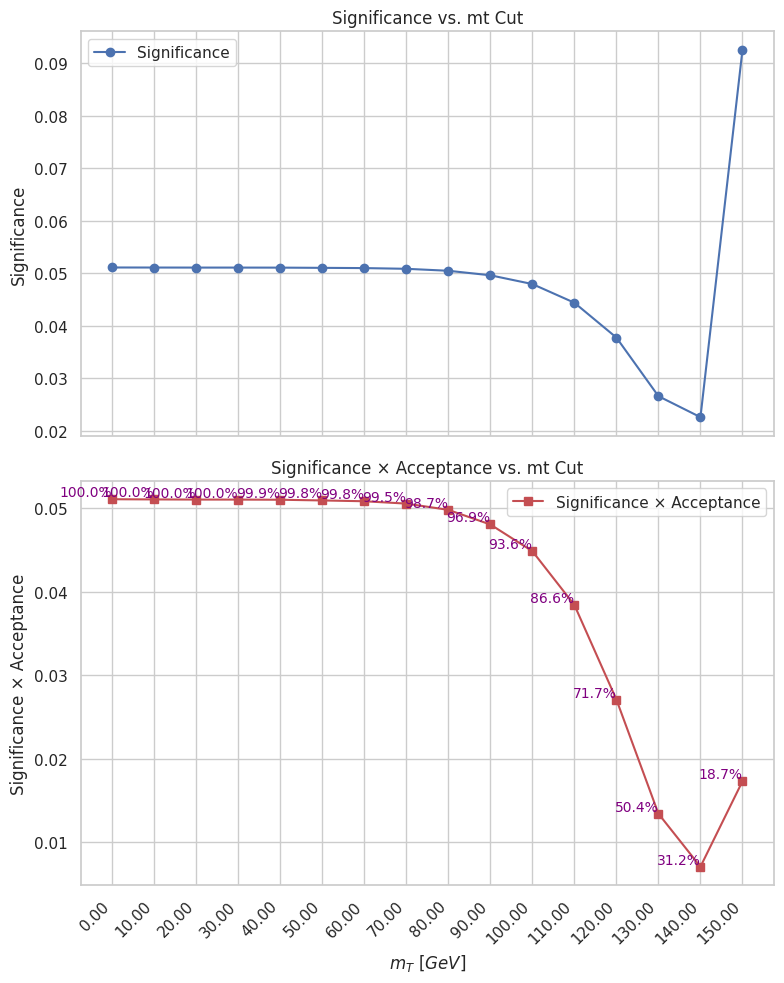

In [ ]:
signal_name = 'ggHyyd'  # Define signal dataset

def getCutDict():
    cut_dict = {}

    cut_dict['met'] = {
        'lowercut': np.arange(70000, 120000 + 5000, 5000),  # met > cut
        'uppercut': np.arange(110000, 300000 + 5000, 5000),  # met < cut
    }
    cut_dict['ph_pt'] = {
        'lowercut': np.arange(0, 80000 + 5000, 5000),  # ph_pt > cut
        'uppercut': np.arange(100000, 300000 + 10000, 10000),  # ph_pt > cut
    }
    cut_dict['dphi_met_phterm'] = {
        'lowercut': np.arange(0, 2 + 0.1, 0.1), # dphi_met_phterm > cut
        'uppercut': np.arange(2, 3.1 + 0.1, 0.1), # dphi_met_phterm < cut
    }
    cut_dict['metsig'] = {
        'lowercut': np.arange(0, 10 + 1, 1), # metsig > cut
        'uppercut': np.arange(10, 30 + 1, 1), # metsig < cut 
    }
    cut_dict['ph_eta'] = {
        'uppercut': np.arange(0, 2.5 + 0.1, 0.1), # ph_eta < cut
    }
    cut_dict['dmet'] = {
        'lowercut': np.arange(-30000, 0 + 5000, 5000), # dmet > cut
        'uppercut': np.arange(10000, 100000 + 5000, 5000), # -10000 < dmet < cut
    }
    cut_dict['dphi_met_jetterm'] = {
        'lowercut': np.arange(0.5, 2.5+0.05, 0.05), # dphi_met_jetterm < cut 
    }
    cut_dict['mt'] = {
        'lowercut': np.arange(70, 150+10, 10), # mt > cut
        'uppercut': np.arange(120, 300+10, 10) # mt < cut
    }
    return cut_dict
cut_config = getCutDict()

def calculate_significance(cut_var, cut_values):
    significance_values = []
    significance_acceptance_values = []
    acceptance_values = []  # Store acceptance percentages

    for cut in cut_values:
        sig_after_cut = 0
        bkg_after_cut = []
        sig_events = 0
        bkg_before_cut = [] # can be used later
        for i in range(len(ntuple_name)):
            fb = tot[i]
            process = ntuple_name[i]
            var_config = getVarDict(fb, process, var_name=cut_var)

            # print(cut_var)
            x = var_config[cut_var]['var']

            if process == signal_name:
                sig_events = getWeight(fb, process)
                if cut_var in ['ph_eta', 'dphi_met_jetterm']:
                    sig_mask = x < cut
                elif cut_var in ['dmet']:
                    mask1 = x > -10000
                    mask2 = x < cut
                    sig_mask = mask1 * mask2
                else:
                    mask1 = x < 170
                    mask2 = x > cut
                    bkg_mask = mask1 * mask2
                    sig_mask = x > cut
                sig_after_cut = ak.sum(sig_events[sig_mask])
            
            else:
                bkg_events = getWeight(fb, process)
                if cut_var in ['ph_eta', 'dphi_met_jetterm']:
                    bkg_mask = x < cut
                elif cut_var in ['dmet']:
                    mask1 = x > -10000
                    mask2 = x < cut
                    bkg_mask = mask1 * mask2
                else:
                    mask1 = x < 170
                    mask2 = x > cut
                    bkg_mask = mask1 * mask2
                    # bkg_mask = x > cut
                bkg_after_cut.append(ak.sum(bkg_events[bkg_mask]))

        # Calculate significance
        significance = sig_after_cut / np.sqrt(sum(bkg_after_cut)) if sum(bkg_after_cut) > 0 else 0

        # Acceptance: ratio of surviving signal events
        acceptance = sig_after_cut / sum(sig_events) if sum(sig_events) > 0 else 0
        acceptance_values.append(acceptance * 100)  # Convert to percentage

        significance_values.append(significance)
        significance_acceptance_values.append(significance * acceptance)

    return significance_values, significance_acceptance_values, acceptance_values

# Compute significance for each variable
for cut_var, cut_values in cut_configs.items():
    significance_values, significance_acceptance_values, acceptance_values = calculate_significance(cut_var, cut_values)

    # Plot results
    fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

    # Top plot: Significance vs. Cut
    ax_top.plot(cut_values, significance_values, marker='o', label='Significance')
    ax_top.set_ylabel('Significance')
    ax_top.set_title(f'Significance vs. {cut_var} Cut')
    ax_top.legend()
    ax_top.grid(True)

    # Bottom plot: Significance * Acceptance vs. Cut
    ax_bot.plot(cut_values, significance_acceptance_values, marker='s', color='r', label='Significance × Acceptance')
    for i, txt in enumerate(acceptance_values):
        ax_bot.text(cut_values[i], significance_acceptance_values[i], f'{txt:.1f}%', 
                    fontsize=10, ha='right', va='bottom', color='purple')
        
    ax_bot.set_xlabel(f'{cut_var} Cut (GeV)')
    ax_bot.set_ylabel('Significance × Acceptance')
    ax_bot.set_title(f'Significance × Acceptance vs. {cut_var} Cut')
    ax_bot.set_xticks(cut_configs[cut_var])
    ax_bot.set_xticklabels(ax_bot.get_xticks(), rotation=45, ha='right')
    ax_bot.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    var_configs_tmp = getVarDict(tot[0], signal_name, cut_var)
    ax_bot.set_xlabel(var_configs_tmp[cut_var]['title'])
    ax_bot.legend()
    ax_bot.grid(True)

    plt.tight_layout()
    plt.savefig(f"../before_cut/significance_{cut_var}.png")
    print(f"Successfully saved to significance_{cut_var}.png")


In [145]:
jet_sum_tmp = ak.sum(fb['jet_central_pt'], axis=-1)
mask = jet_sum_tmp != 0 # True for events where jet_sum is not 0.
balance = (fb['met_tst_et'][mask] + ak.firsts(fb['ph_pt'])[mask]) / jet_sum_tmp[mask]

In [146]:
def findnone(arr):
    mask = ak.is_none(arr)

    n_none = ak.sum(mask)
    print("Number of None values:", n_none)

In [201]:
# Compute sqrt(B_counts) in a safe way
sqrt_B = np.sqrt(B_counts)
# Use np.where to avoid division by zero:
sig_per_bin = np.where(B_counts > 0, S_counts / sqrt_B, 0)
# Replace any possible NaNs with 0:
sig_per_bin = np.nan_to_num(sig_per_bin)



/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


In [ ]:
var = {
    'ntuple': [ntuple_name[i]] * len(fb),
    'vtx_sumPt': fb['vtx_sumPt'],
    'n_ph': fb['n_ph'],
    'n_ph_baseline': fb['n_ph_baseline'],
    'n_el_baseline': fb['n_el_baseline'],
    'n_mu_baseline': fb['n_mu_baseline'],
    'n_tau_baseline': fb['n_tau_baseline'],
    'puWeight': fb['pu_weight'],
    'actualIntPerXing': fb['actualIntPerXing'],
    'mt': np.sqrt(2 * fb['met_tst_et'] * ak.firsts(fb['ph_pt']) * (1 - np.cos(fb['met_tst_phi'] - ak.first(fb['ph_phi'])))) / 1000,
    'metsig': fb['met_tst_sig'],
    'metsigres': fb['met_tst_et'] / fb['met_tst_sig'],
    'met': fb['met_tst_et'] + 50000,  # applying the '+50000' shift
    'met_noJVT': fb['met_tst_noJVT_et'],
    'met_cst': fb['met_cst_et'],
    'met_track': fb['met_track_et'],
    'dmet': fb['met_tst_noJVT_et'] - fb['met_tst_et'],
    'ph_pt': ak.first(fb['ph_pt']) - 150000,  # applying the '-150000' shift
    'ph_eta': np.abs(ak.first(fb['ph_eta'])),
    'ph_phi': ak.first(fb['ph_phi']),
    'jet_central_eta': ak.first(fb['jet_central_eta']),
    'jet_central_pt1': ak.first(fb['jet_central_pt']),
    'jet_central_pt2': fb['jet_central_pt'][:, 1],
    'jet_central_pt': fb['jet_central_pt'],
    'dphi_met_phterm': np.arccos(np.cos(fb['met_tst_phi'] - fb['met_phterm_phi'])),
    'dphi_met_ph': np.arccos(np.cos(fb['met_tst_phi'] - ak.first(fb['ph_phi']))),
    'dphi_met_jetterm': np.where(fb['met_jetterm_et'] != 0,
                                  np.arccos(np.cos(fb['met_tst_phi'] - fb['met_jetterm_phi'])),
                                  0),
    'dphi_phterm_jetterm': np.where(fb['met_jetterm_et'] > 0,
                                    np.arccos(np.cos(fb['met_phterm_phi'] - fb['met_jetterm_phi'])),
                                    4),
    'dphi_ph_centraljet1': np.arccos(np.cos(ak.first(fb['ph_phi']) - ak.first(fb['jet_central_phi']))),
    'dphi_ph_jet1': np.arccos(np.cos(ak.first(fb['ph_phi']) - ak.first(fb['jet_central_phi']))),
    'dphi_central_jet1_jet2': np.arccos(np.cos(fb['jet_central_phi'][0] - fb['jet_central_phi'][1])),
    'metplusph': fb['met_tst_et'] + ak.first(fb['ph_pt']),
    'failJVT_jet_pt': fb['failJVT_jet_pt'],
    'failJVT_jet_pt1': ak.first(fb['failJVT_jet_pt']),
    'softerm': fb['met_softerm_tst_et'],
    'jetterm': fb['met_jetterm_et'],
    'jetterm_sumet': fb['met_jetterm_sumet'],
    'n_jet': fb['n_jet'],
    'n_jet_central': fb['n_jet_central'],
    'n_jet_fwd': fb['n_jet'] - fb['n_jet_central'],
    'vertex': np.abs(fb['pv_truth_z'][0] - fb['pv_z'][0]) == np.min(np.abs(fb['pv_truth_z'][0] - fb['pv_z'])),
    'goodPV': np.abs(fb['pv_truth_z'][0] - fb['pv_z'][0]) <= 0.5,
    'dphi_met_central_jet': np.arccos(np.cos(fb['met_tst_phi'] - ak.first(fb['jet_central_phi']))),
    'counts': 0.5,
    'jet_central_timing1': ak.first(fb['jet_central_timing']),
    'jet_central_timing': fb['jet_central_timing'],
    'jet_central_emfrac': fb['jet_central_emfrac'],
    'jet_central_emfrac1': ak.first(fb['jet_central_emfrac']),
    'balance': (fb['met_tst_et'] + ak.first(fb['ph_pt'])) / np.sum(fb['jet_central_pt']),
    'balance_sumet': (fb['met_tst_et'] + ak.first(fb['ph_pt'])) / fb['met_jetterm_sumet'],
    'central_jets_fraction': np.where(fb['n_jet'] > 0, fb['n_jet_central'] / fb['n_jet'], -1),
    'trigger': fb['trigger_HLT_g50_tight_xe40_cell_xe70_pfopufit_80mTAC_L1eEM26M'],
    'dphi_jj': np.arccos(np.cos(fb['jet_central_phi'][1] - fb['jet_central_phi'][0])) if len(fb['jet_central_phi']) > 1 else -1,
}


In [ ]:
dict={}
dict['allcut'] = {
    'str': (
        'met_tst_et > 100000 && '
        'trigger_HLT_g50_tight_xe40_cell_xe70_pfopufit_80mTAC_L1eEM26M && '
        'ph_pt[0] > 50000 && ' 
        'ph_pt[0] < 200000 && '
        '(met_tst_noJVT_et-met_tst_et) > -60000 && ' # dmet
        '(met_tst_noJVT_et-met_tst_et) < 60000 && '
        'sqrt(2*met_tst_et*ph_pt[0]*(1-cos(met_tst_phi-ph_phi[0])))/1000 > 40 && ' # mt
        'sqrt(2*met_tst_et*ph_pt[0]*(1-cos(met_tst_phi-ph_phi[0])))/1000 < 200 && '
        '((met_jetterm_et!=0)*Alt$(acos(cos(met_tst_phi-met_jetterm_phi)),0)+(met_jetterm_et==0)*0) < 1.5 && ' # dphi_met_jetterm
        '(met_tst_et+ph_pt[0])/Sum$(jet_central_pt) <= 12' # balance
    )}
dict['allcut']['str']